## Census Dataset Analysis

The United States Census of 2018 collected broad information about the US Government employees, including demographic information $Z$, ($Z_1$ for age, $Z_2$ for race, $Z_3$ for nationality), gender $X$, ($x_0$ female, $x_1$ male), marital and family status $M$, education info $L$, and work info $R$

### loading in modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as robjects
import rpy2.robjects.pandas2ri as pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr, isinstalled
import rpy2.robjects.packages as rpackages
from rpy2.robjects import r
import sys

import sys
sys.path.insert(0, '/Users/alanma/Documents/CFA_python')
import faircause.faircause as faircause


In [2]:
# Ensure faircause is installed (either using conda or R)

print("Is faircause installed now?", isinstalled('faircause'))


Is faircause installed now? True


### loading in dataset

In [3]:
# import
base = importr('base')
faircause = importr('faircause')

# Load census dataset
data = robjects.r('''
    data("gov_census", package = "faircause")
    gov_census[seq_len(20000), ]  # Take first 20000 rows as in the vignette
''')

# Rename columns to match the vignette
data.columns = ['sex', 'age', 'race', 'hispanic_origin', 'citizenship', 'nativity',
                'marital', 'family_size', 'children', 'education_level', 'english_level',
                'salary', 'hours_worked', 'weeks_worked', 'occupation', 'industry',
                'economic_region']

# Convert to pd
with localconverter(robjects.default_converter + pandas2ri.converter):
  data = robjects.conversion.rpy2py(data)
data.reset_index(drop=True, inplace=True)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [4]:
data.head()

,sex,age,race,hispanic_origin,citizenship,nativity,marital,family_size,children,education_level,english_level,salary,hours_worked,weeks_worked,occupation,industry,economic_region
0,male,64.0,black,no,1.0,native,married,2.0,0.0,20.0,0.0,43000.0,56.0,49.0,13-1081,928P,Southeast
1,female,54.0,white,no,1.0,native,married,3.0,1.0,20.0,0.0,45000.0,42.0,49.0,29-2061,6231,Southeast
2,male,38.0,black,no,1.0,native,married,3.0,1.0,24.0,0.0,99000.0,50.0,49.0,25-1000,611M1,Southeast
3,female,41.0,asian,no,1.0,native,married,3.0,1.0,24.0,0.0,63000.0,50.0,49.0,25-1000,611M1,Southeast
4,female,40.0,white,no,1.0,native,married,4.0,2.0,21.0,0.0,45200.0,40.0,49.0,27-1010,611M1,Southeast


In [5]:
# placing columns
X = "sex"
W = ["marital", "family_size", "children", "education_level",
    "english_level", "hours_worked", "weeks_worked", "occupation",
    "industry"]
Z = ["age", "race", "hispanic_origin", "citizenship", "nativity",
    "economic_region"]
Y = "salary"
x0 = "male"
x1 = "female"


### Prelims

A data scientist loads the data and performs the following initial analysis:

In [6]:
np.mean(data[Y][data[X] == x1]) - np.mean(data[Y][data[X] == x0])

np.float64(-15053.691747379096)

Therefore, the data scientist observed that male employees on average earn $15000/year more than female employees, that is
$$E[y-x_1] - E[y - x_0] = 15054$$


### CFA

Following the Fairness Cookbook, the data scientist does the following:

SFM projection: the SFM projection of the causal diagram 
$G$ of this dataset is given by
$$\Pi_{SFM} (G) = \langle X = \{X\}, Z = \{Z_1, Z_2, Z_3\}, W = \{M, L, R\}, Y = \{Y\}\rangle$$
She then inputs this SFM projection into the faircause Python package,



In [7]:
import faircause.faircause as faircause

fc_census = faircause.FairCause(data, X, Z, W, Y, x0, x1, method='debiasing')

In [8]:
print(fc_census)

faircause object:

Attribute:       sex
Outcome:         salary
Confounders:     marital, family_size, children, education_level, english_level, hours_worked, weeks_worked, occupation, industry
Mediators:       age, race, hispanic_origin, citizenship, nativity, economic_region


In [9]:
fc_census.estimate_effects()

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid's binary_logloss: 0.685863 + 0.00343191
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid's rmse: 41635.4 + 2723.71
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid's binary_logloss: 0.515804 + 0.00661485
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid's rmse: 32871.2 + 2879.3
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid's rmse: 24104 + 1863.59
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid's rmse: 26062.4 + 1665.55
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid's binary_logloss: 0.686315 + 0.0038006
Training until validation score

In [14]:
fc_census.summary()

faircause object summary:

Protected attribute:                 sex
Protected attribute levels:          male, female
Total Variation (TV): -15053.6917

TV decomposition(s):

TV_malefemale(y) (-15053.6917) = CtfDE_malefemale(y | male) (-7774.1587) - CtfIE_femalemale(y | male) (8588.6999) - CtfSE_femalemale(y) (-1309.1669)


,measure,value,sd
0,tv,-15053.691747,1050.799189
1,ctfde,-7774.158675,762.297314
2,ctfie,8588.699927,668.569644
3,ctfse,-1309.166855,733.564698
4,ett,-16362.858602,610.483729


/Users/alanma/Documents/CFA_python/faircause/utils/generics.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Measure', y='Value', data=df, palette='Set2')
/Users/alanma/Documents/CFA_python/faircause/utils/generics.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([rename.get(m, m) for m in df['Measure']], rotation=45, ha='right')


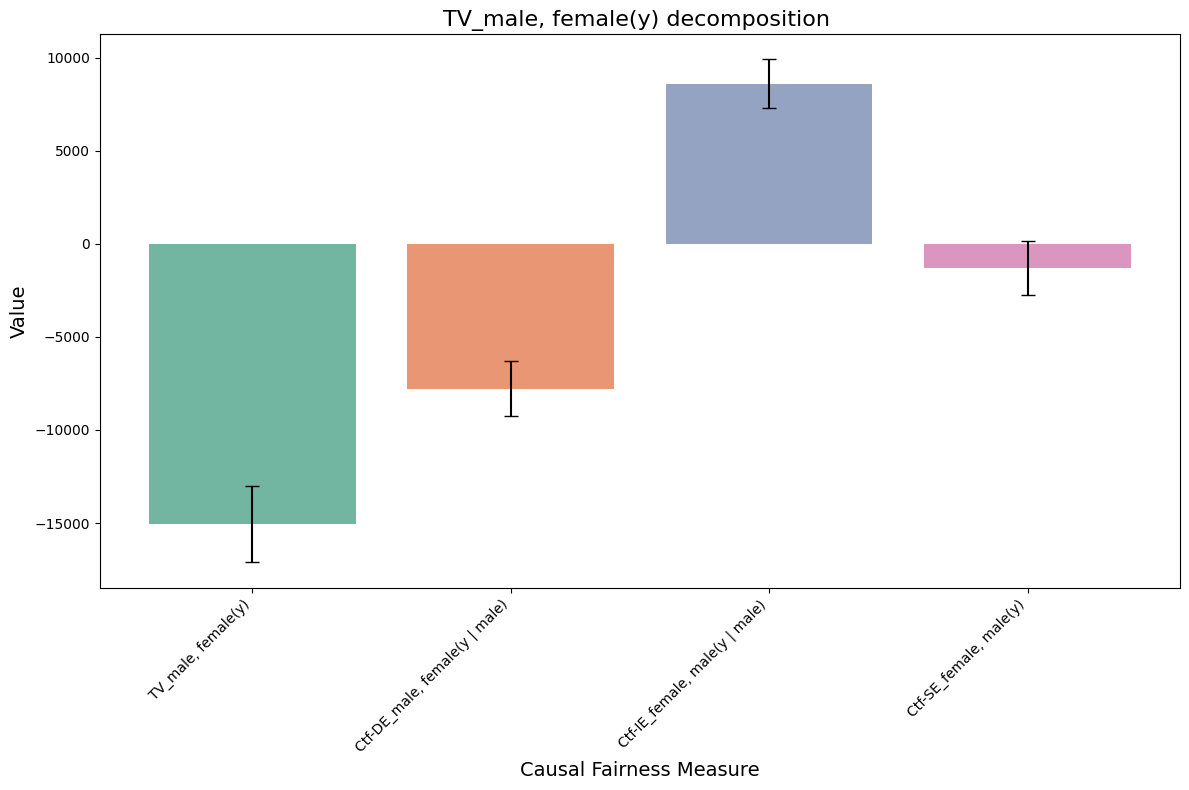

In [15]:
plot = fc_census.plot()


Using these results, she considers the following: 

\textbf{Disparate treatment:} when considering disparate treatment, she computes $x\text{-DE}_{x_0, x_1}(y | x_0)$ and its 95% CI to be
$$x\text{-DE}_{x_0, x_1}(y|x_0)= 	-9920.48 \pm 1461.94$$
The hypothesis $H_0^{(x\text{-DE})}$ is thus rejected, providing evidence of disparate treatment

In [12]:
fc_census.summary()

faircause object summary:

Protected attribute:                 sex
Protected attribute levels:          male, female
Total Variation (TV): -15053.6917

TV decomposition(s):

TV_malefemale(y) (-15053.6917) = CtfDE_malefemale(y | male) (-7774.1587) - CtfIE_femalemale(y | male) (8588.6999) - CtfSE_femalemale(y) (-1309.1669)


,measure,value,sd
0,tv,-15053.691747,1050.799189
1,ctfde,-7774.158675,762.297314
2,ctfie,8588.699927,668.569644
3,ctfse,-1309.166855,733.564698
4,ett,-16362.858602,610.483729


In [13]:
x[x['measure'] == 'tv']['value']

NameError: name 'x' is not defined